# Using MLFlow to track model training
In this script below, I use MLFlow to track models.

In [1]:
pip show azure-ai-ml

Name: azure-ai-ml
Version: 1.16.1
Summary: Microsoft Azure Machine Learning Client Library for Python
Home-page: https://github.com/Azure/azure-sdk-for-python
Author: Microsoft Corporation
Author-email: azuresdkengsysadmins@microsoft.com
License: MIT License
Location: /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages
Requires: azure-common, azure-core, azure-mgmt-core, azure-storage-blob, azure-storage-file-datalake, azure-storage-file-share, colorama, isodate, jsonschema, marshmallow, msrest, opencensus-ext-azure, opencensus-ext-logging, pydash, pyjwt, pyyaml, strictyaml, tqdm, typing-extensions
Required-by: 
Note: you may need to restart the kernel to use updated packages.


My credentials, subscription id, resource group and workspace info, are all stored in a file called config.py. You have to make sure that you have yours in that file.

In [2]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

# My subscription id, resource group and workspace are all in the file below.
import config

In [5]:
ml_client = MLClient(
    DefaultAzureCredential(), config.subscription_id, config.resource_group, config.workspace
)

In [7]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

## Loading the Data
I load the data that I prepared before.

In [2]:
os.listdir('data/')

['.amlignore', '.amlignore.amltmp', 'titanic', 'titanic_ds.csv']

In [3]:
# Let' load the data first

df = pd.read_csv('data/titanic_ds.csv')
df.head()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male
0,0,3,22.0,1,0,7.2500,0,1
1,1,1,38.0,1,0,71.2833,1,0
2,1,3,26.0,0,0,7.9250,1,0
3,1,1,35.0,1,0,53.1000,1,0
4,0,3,35.0,0,0,8.0500,0,1


In [5]:
# Preparing the datasets to train and test

X = df.drop(['Survived'], axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [6]:
import mlflow
experiment_name = "titanic-lives"
mlflow.set_experiment(experiment_name)

2024/08/22 15:58:25 INFO mlflow.tracking.fluent: Experiment with name 'titanic-lives' does not exist. Creating a new experiment.


<Experiment: artifact_location='', creation_time=1724342305738, experiment_id='b00b7589-65e1-4d9d-87da-fc4915b71257', last_update_time=None, lifecycle_stage='active', name='titanic-lives', tags={}>

In [8]:
# Training the model with autologging. The "sklearn" in between mlflow and autolog is called
# the 'flavor' of autolog!

with mlflow.start_run():
    mlflow.sklearn.autolog()

    model = LogisticRegression(C=1/0.1, solver="liblinear").fit(X_train, y_train)

2024/08/22 16:15:12 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2024/08/22 16:15:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https:

In [9]:
# But instead of logging all the metrics, you can customize the parameters and the metrics to log.
# The following code demonstrates that

mlflow.sklearn.autolog(disable=True)

with mlflow.start_run():
    model = LogisticRegression(C=1/0.1, solver="liblinear").fit(X_train, y_train)

    y_hat = model.predict(X_test)
    acc = np.average(y_hat == y_test)

    mlflow.log_param("regularization_rate", 0.1)
    mlflow.log_metric("Accuracy", acc)

In [10]:
# We can choose a different regularization parameter and run it again.

with mlflow.start_run():
    model = LogisticRegression(C=1/0.01, solver="liblinear").fit(X_train, y_train)

    y_hat = model.predict(X_test)
    acc = np.average(y_hat == y_test)

    mlflow.log_param("regularization_rate", 0.01)
    mlflow.log_metric("Accuracy", acc)

In [11]:
# Now let's try a different machine learning model, like Decision Trees

from sklearn.tree import DecisionTreeClassifier

with mlflow.start_run():
    model = DecisionTreeClassifier().fit(X_train, y_train)

    y_hat = model.predict(X_test)
    acc = np.average(y_hat == y_test)

    mlflow.log_param("estimator", "DecisionTreeClassifier")
    mlflow.log_metric("Accuracy", acc)

In [12]:
# We can also log artifacts, artifacts are files, in our experiment. 
# The code below produces the ROC curve in png format and mlflow saves it as an artifact.

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

with mlflow.start_run():
    model = DecisionTreeClassifier().fit(X_train, y_train)

    y_hat = model.predict(X_test)
    acc = np.average(y_hat == y_test)

    # plot ROC curve
    y_scores = model.predict_proba(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
    fig = plt.figure(figsize=(6, 4))
    # Plot the diagonal 50% line
    plt.plot([0, 1], [0, 1], 'k--')
    # Plot the FPR and TPR achieved by our model
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.savefig("ROC-Curve.png")

    mlflow.log_param("estimator", "DecisionTreeClassifier")
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_artifact("ROC-Curve.png")

Below is the screenshot of the artifact (the png file) I copied from my ML Studio. They are saved!

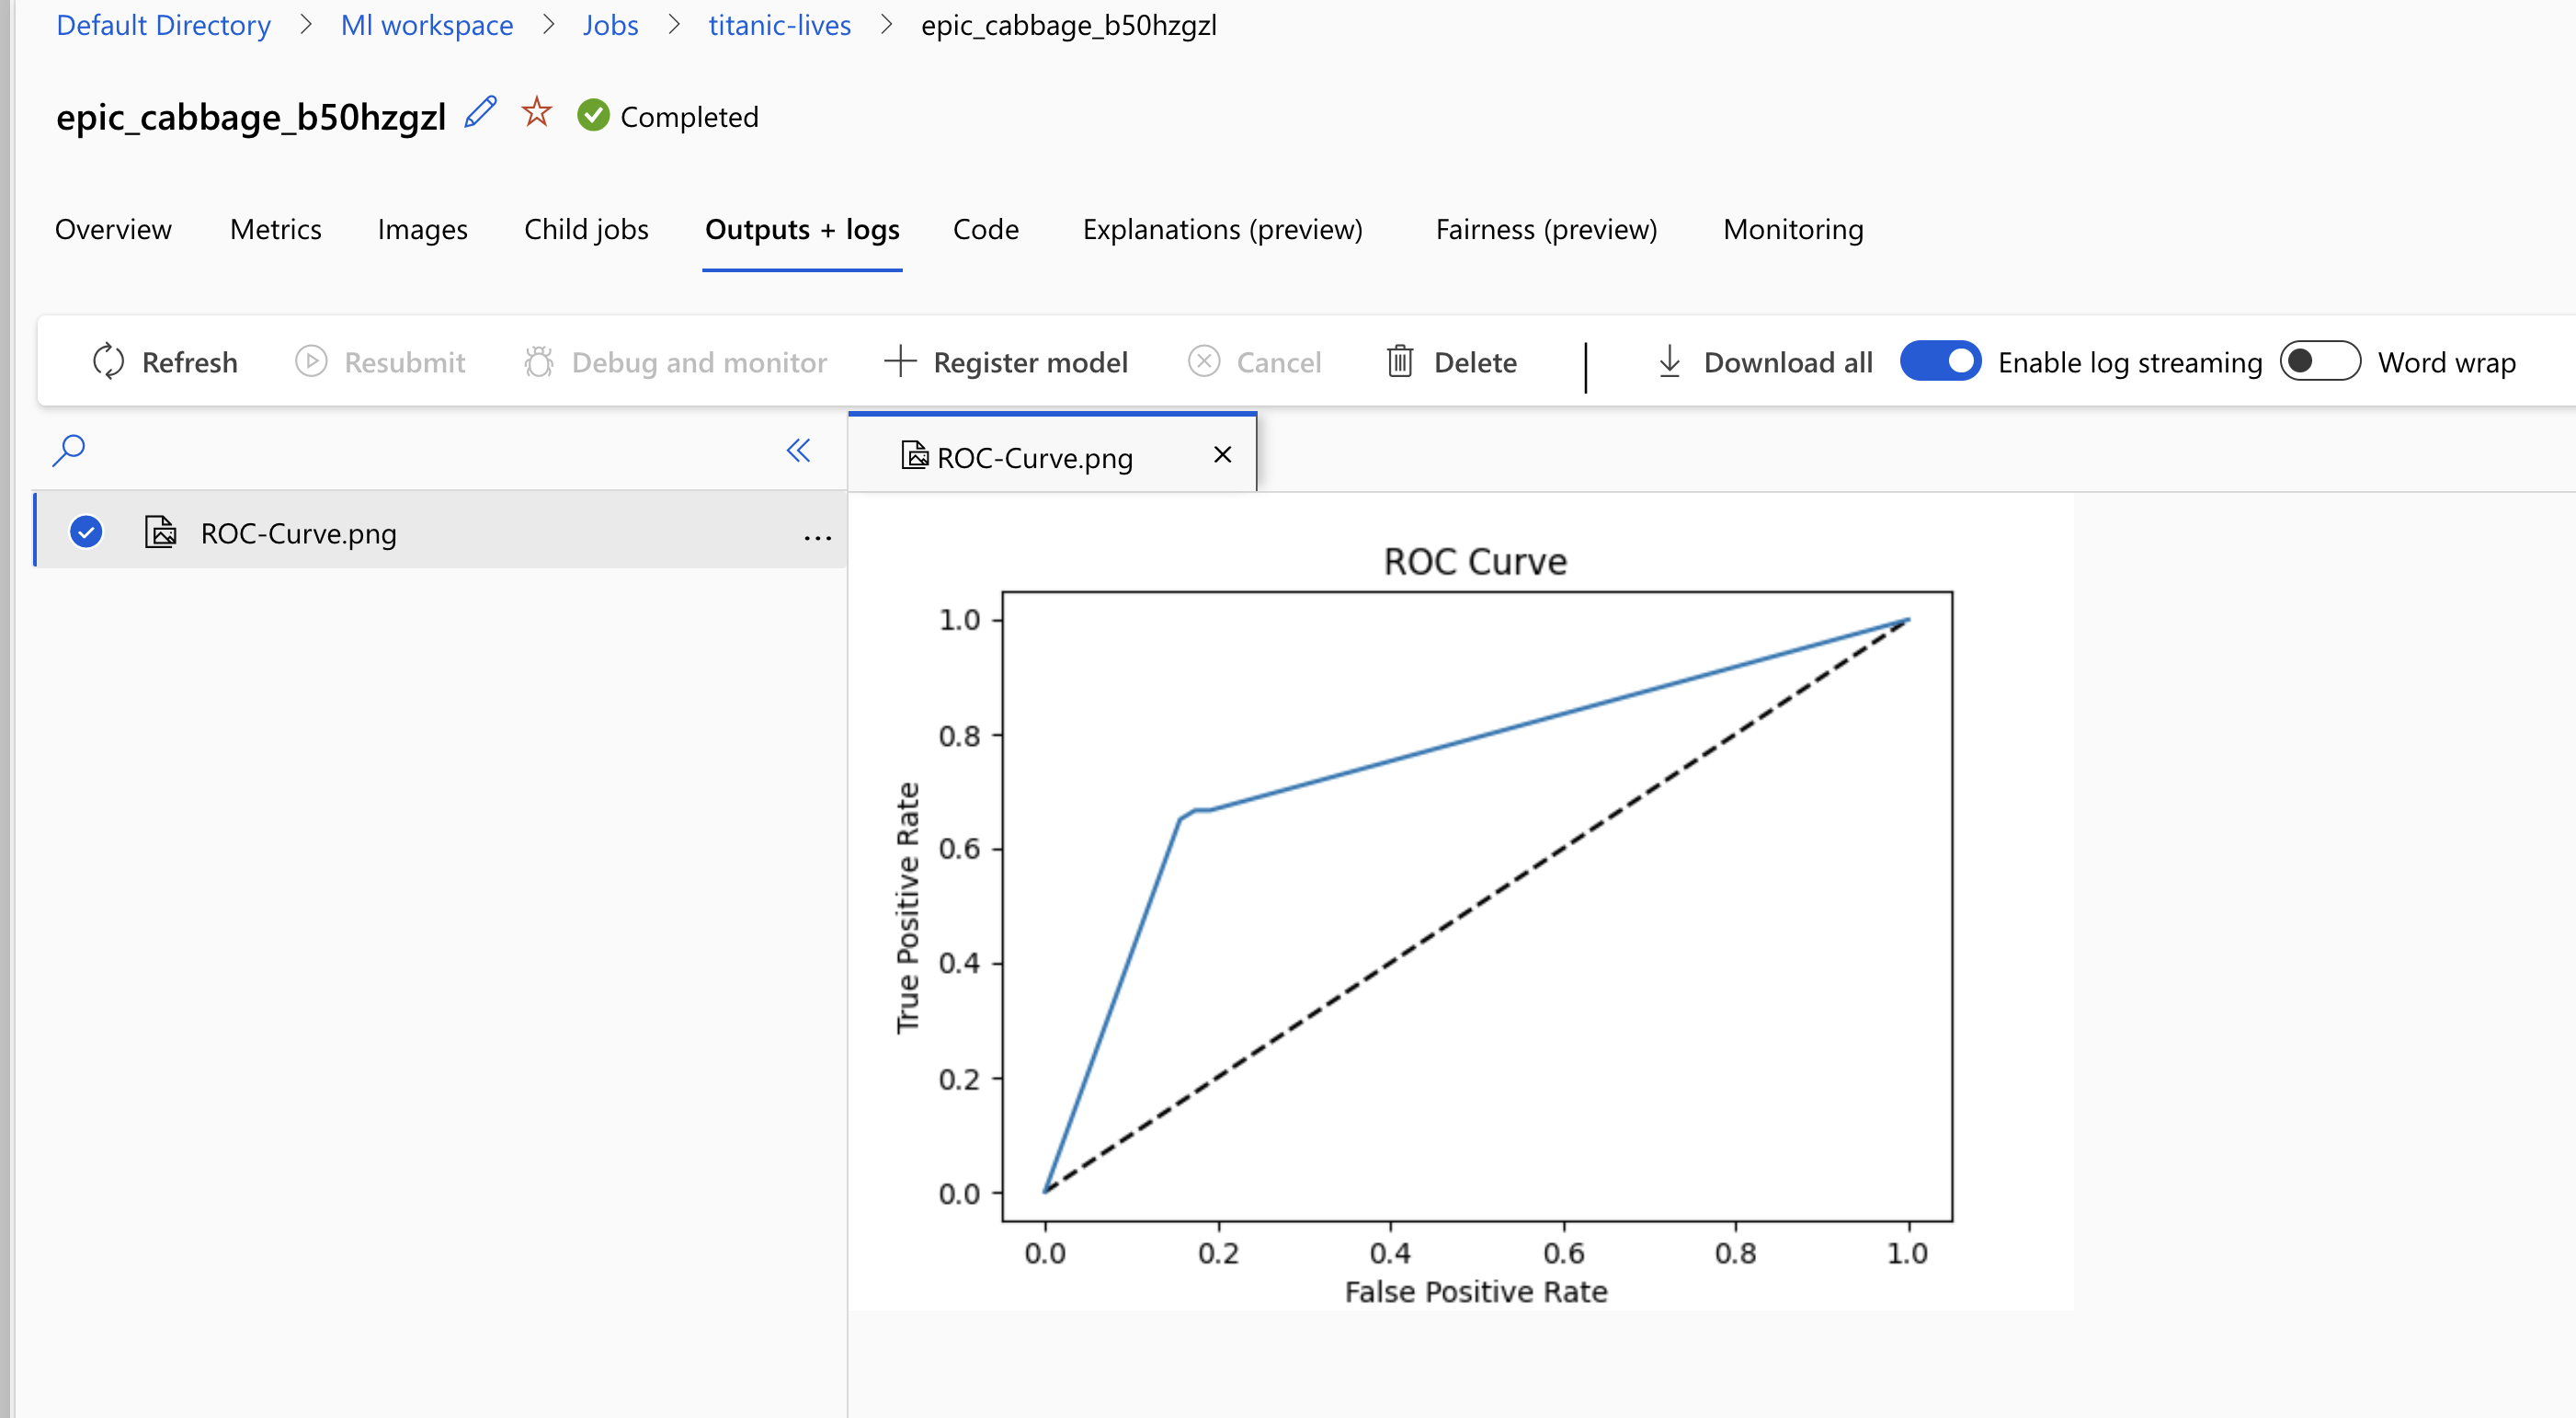